# Keyphrases Graphs

In [1]:
%matplotlib inline 

import networkx as nx 
import seaborn as sns
import graph_tool.all as gt 
import matplotlib.pyplot as plt 

from datetime import datetime 
from collections import Counter
from dateutil.parser import parse as dateparse 
from colors import ColorMap

In [2]:
sns.set_context('talk')
sns.set_style('whitegrid')

In [3]:
g = gt.load_graph('data/tiny_keyphrases.graphml.gz')

In [4]:
def gt_info(g):
    """
    Prints out an info statement similar to networkx. 
    
        Name: Baleen Keyphrase Graph
        Type: Graph
        Number of nodes: 139227
        Number of edges: 257316
        Average degree:   3.6964
    
    Uses an simple format string to do this. 
    """
    
    # Set up the output
    output = []
        
    # Append the graph string properties 
    for key in g.gp.keys(): 
        output.append("{}: {}".format(key.title(), g.gp[key]))
    
    
    # Detect the graph type 
    graph_type = "DiGraph" if g.is_directed() else "Graph"
    output.append("Type: {}".format(graph_type))
    
    # Add the number of nodes and edges 
    output.append("Number of nodes: {:,}".format(g.num_vertices()))
    output.append("Number of edges: {:,}".format(g.num_edges()))
    
    # Add the average degree and standard deviation 
    output.append("Average degree:  {:0.3f}𝜇 {:0.3f}𝜎".format(*gt.vertex_average(g, 'total')))
    
    # Return the info string 
    return "\n".join(output)

In [5]:
print gt_info(g)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 139,227
Number of edges: 257,316
Average degree:  3.696𝜇 0.054𝜎


In [6]:
gtypes = Counter(g.vp.type[v] for v in g.vertices())

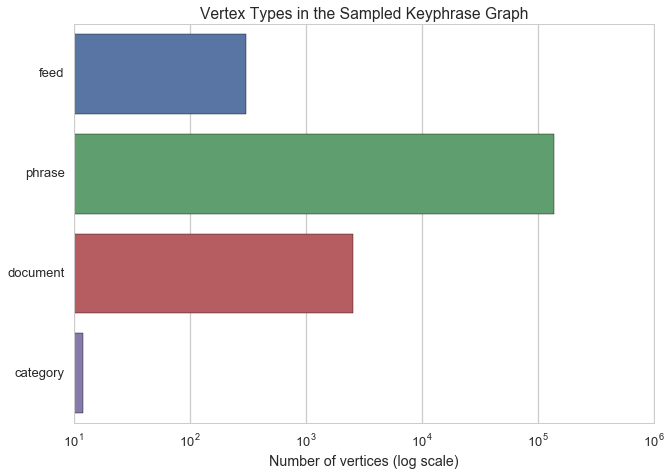

In [7]:
def plot_vertex_types(outpath):
    g = sns.barplot(y=gtypes.keys(), x=gtypes.values(), log=True)
    g.set_title("Vertex Types in the Sampled Keyphrase Graph")
    g.set_xlabel("Number of vertices (log scale)")

    plt.savefig(outpath)

plot_vertex_types("images/keyphrase_vertex_type.png")

In [8]:
def degree_filter(degree=0):
    def inner(vertex):
        return vertex.out_degree() > degree 
    return inner 

g = gt.GraphView(g, vfilt=degree_filter(3))

In [9]:
print gt_info(g)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 8,520
Number of edges: 112,320
Average degree:  26.366𝜇 0.452𝜎


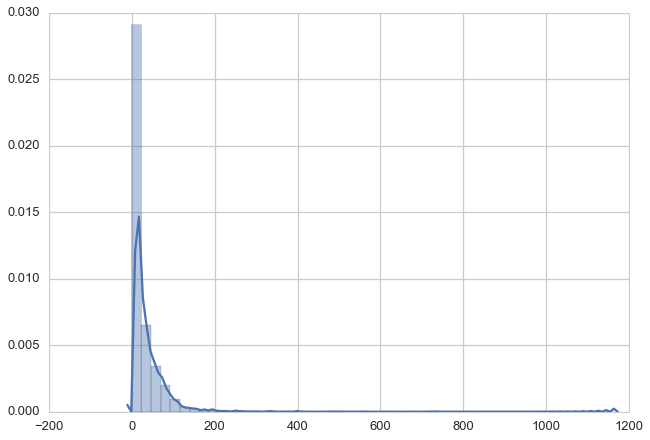

In [10]:
sns.distplot([v.out_degree() for v in g.vertices()], norm_hist=True)

In [11]:
# Get the highest degree document 
for v in g.vertices():
    if g.vp.type[v] == 'document':
        break

In [12]:
def ego_filter(g, ego, hops=2):
    def inner(vertex):
        return gt.shortest_distance(g, ego, vertex) <= hops 
    return inner

In [13]:
ego = gt.GraphView(g, vfilt=ego_filter(g,v, 1))
print gt_info(ego)

Name: Baleen Keyphrase Graph
Type: Graph
Number of nodes: 32
Number of edges: 31
Average degree:  1.938𝜇 0.923𝜎


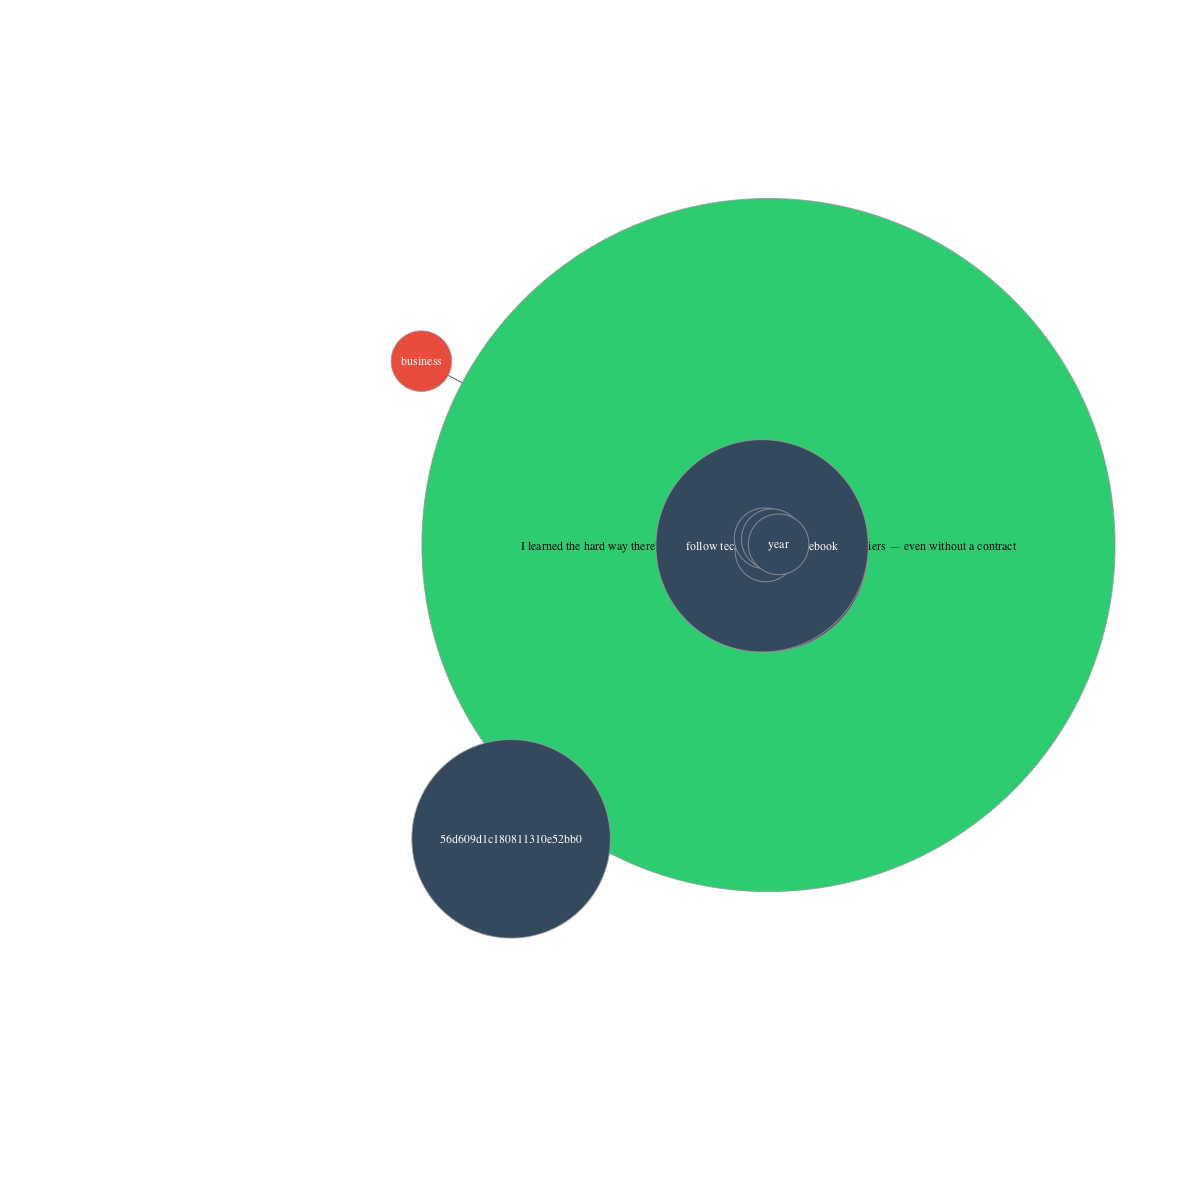

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12401a310, at 0x123eebd10>

In [21]:
doc = ego.vp.title[v].replace(' ', '-').lower()

# Set the vertex label 
vlabel  = ego.new_vertex_property('string')
for vertex in ego.vertices():
    if ego.vp.type[vertex] in ('document', 'feed'):
        vlabel[vertex] = ego.vp.title[vertex]
    elif ego.vp.type[vertex] == 'phrase':
        vlabel[vertex] = ego.vp.phrase[vertex]
    else:
        vlabel[vertex] = ego.vp._graphml_vertex_id[vertex]

vsize = ego.new_vertex_property('int')
for vertex in ego.vertices():
    vsize[vertex] = len(vlabel[vertex])

# Set the vertex color 
vcolor  = ego.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in ego.vertices():
    vcolor[vertex] = vcmap(ego.vp['type'][vertex])

gt.graph_draw(ego, pos=gt.sfdp_layout(ego, eweight=ego.ep.weight),
    vertex_text=vlabel, vertex_shape='none', vertex_pen_width=1,
#     vertex_font_size=22, vertex_size=vsize,
    vertex_fill_color=vcolor, output_size=(1200,1200), 
    output='images/{}.png'.format(doc)
)